---
# Notebook 2: Fine-Tuning LegalBERT for Contract Classification

### **Project:** AI-Powered Contract Document Classification
### **Objective:** The goal of this notebook is to train and evaluate a modern, transformer-based NLP model for our classification task. We will use **LegalBERT**, a model pre-trained specifically on legal text, and fine-tune it on our synthetic contract dataset. This will serve as our advanced model to compare against the classical TF-IDF baseline.

**Key Concepts:**
* **Transfer Learning:** We are not training a model from scratch. Instead, we are taking a powerful, pre-trained model (LegalBERT) that already has a deep understanding of legal language and adapting it to our specific classification task.
* **Fine-Tuning:** This adaptation process is called fine-tuning. It's highly efficient and allows us to achieve state-of-the-art performance with a relatively small dataset.

**Steps:**
1.  **Environment Setup:** Install the necessary libraries (`transformers`, `torch`, `datasets`) and configure our device to use a GPU if available.
2.  **Data Loading & Preparation:** Load the `contracts.csv` dataset and convert our text-based category labels into a numerical format that the model can understand.
3.  **Tokenization:** Use the specific tokenizer that comes with LegalBERT to convert our processed text into a format of numerical IDs that the model expects.
4.  **Dataset Creation:** Structure our tokenized data into a PyTorch-compatible `Dataset` object, which is the standard way to feed data into the Hugging Face `Trainer`.
5.  **Model Training:** Configure and run the training process using the powerful Hugging Face `Trainer` API, which automates the training loop, optimization, and logging.
6.  **Model Evaluation:** Evaluate the fine-tuned model on our unseen test set and compare its performance to our baseline model using the same metrics (Accuracy, F1-score, Confusion Matrix).

In [1]:
# --- Environment Setup ---

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# --- Configure Device (GPU/CPU) ---
# Check if a GPU is available and set the device accordingly.
# This is crucial for training transformer models efficiently.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


-----
### 2\. Data Loading & Preparation

We'll start by loading our dataset. Unlike our first notebook, we will use the **original, unprocessed text** here. The LegalBERT tokenizer is highly sophisticated and is trained to handle raw text with punctuation and casing, so we don't need our custom `preprocess_text` function.

The key preparation step is to convert our string labels (e.g., 'NDA') into integer labels (e.g., 2), as this is the format required by the model.

In [2]:
# --- Load the Dataset ---
data_path = "contracts.csv"
df = pd.read_csv(data_path)

# --- Encode the Labels ---
# Models require numerical labels. We use LabelEncoder to convert text labels to integers.
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])

# We'll keep a mapping of integers to labels for later interpretation.
id2label = {i: label for i, label in enumerate(label_encoder.classes_)}
label2id = {label: i for i, label in enumerate(label_encoder.classes_)}

print("Label mapping created:")
print(id2label)

# --- Split the Data ---
# We split the data into training and testing sets, ensuring stratification.
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"\nTraining set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

# Display the first few rows with the new 'label' column
display(train_df.head())

Label mapping created:
{0: 'Employment', 1: 'NDA', 2: 'Partnership', 3: 'SLA', 4: 'Vendor'}

Training set size: 800
Testing set size: 200


,text,category,label
193,"Confidential Information. IN WITNESS WHEREOF, ...",NDA,1
723,This document constitutes the entire agreement...,SLA,3
972,response time. This document constitutes the e...,SLA,3
614,Force Majeure. Neither party shall be liable f...,Vendor,4
333,payment terms. This Agreement may be executed ...,Vendor,4


### 3\. Tokenization

Next, we'll tokenize our text. We must use the specific tokenizer associated with our chosen pre-trained model, `nlpaueb/legal-bert-base-uncased`. The tokenizer will convert our raw text strings into the numerical input IDs that the model expects. We'll also convert our pandas DataFrames into Hugging Face `Dataset` objects, which is the standard format for the `Trainer` API.

-----

In [3]:
# --- Load the Tokenizer ---
# We specify the model we want to use from the Hugging Face Hub.
model_checkpoint = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# --- Convert DataFrames to Hugging Face Datasets ---
# The Trainer API works best with objects from the `datasets` library.
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# --- 3.3 Create the Tokenization Function ---
def tokenize_function(examples):
    """
    Applies the tokenizer to a batch of examples.
    We set padding to 'max_length' and truncation to True to handle
    any variance in document length.
    """
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512 # LegalBERT's maximum input length
    )

# --- 3.4 Apply Tokenization to the Datasets ---
# The .map() method is a highly efficient way to apply the function to the entire dataset.
print("Tokenizing the datasets...")
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

print("\nTokenization complete.")
print("Example of a tokenized input:")
print(tokenized_train_dataset[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizing the datasets...


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]


Tokenization complete.
Example of a tokenized input:
{'text': 'Confidential Information. IN WITNESS WHEREOF, the parties have executed this Agreement as of the date first above written.. Any notice or other communication given hereunder shall be in writing and shall be deemed given.. trade secrets. Disclosing Party. This Agreement shall terminate upon the completion of the services described herein.. Receiving Party. The relationship of the parties is that of independent contractors.. The headings in this Agreement are for convenience only and shall not affect its interpretation..', 'category': 'NDA', 'label': 1, '__index_level_0__': 193, 'input_ids': [101, 829, 286, 117, 213, 1480, 2469, 115, 207, 276, 247, 745, 226, 232, 221, 210, 207, 254, 296, 348, 436, 117, 117, 220, 326, 215, 231, 1496, 467, 572, 224, 219, 213, 699, 212, 224, 219, 596, 467, 117, 117, 616, 3899, 117, 3952, 257, 117, 226, 232, 224, 1168, 306, 207, 1654, 210, 207, 410, 735, 531, 117, 117, 1843, 257, 117, 207, 1389,

The tokenization process has successfully completed. The output shows a sample from our training dataset, now enriched with three new key-value pairs that are essential for the transformer model:

* **`input_ids`**: This is the core result of tokenization. It's a list of integers where each number is a unique ID that maps to a specific token (a word or sub-word) in the LegalBERT vocabulary.
* **`attention_mask`**: This is a list of 1s and 0s that tells the model which tokens to pay attention to. The 0s correspond to the padding tokens at the end, which are used to make all sequences the same length (`max_length=512`).
* **`token_type_ids`**: For this single-text classification task, this is a list of 0s and is not critical. It's used in other tasks that involve comparing two different sentences.

The text data has now been fully converted into the precise numerical format that the LegalBERT model requires for training.

### 4\. Model Training

With our datasets tokenized and ready, we can now configure and launch the training job. This involves three steps:

1.  **Load the Pre-trained Model:** We'll download the LegalBERT model from the Hugging Face Hub. This model has a pre-trained base but a new, untrained classification head on top, which will be trained to recognize our specific contract categories.
2.  **Define Training Arguments:** We need to specify all the hyperparameters for our training run, such as the learning rate, number of epochs, and batch size.
3.  **Initialize and Run the Trainer:** We'll use the Hugging Face `Trainer` class, which handles the entire training and evaluation loop for us.

-----

In [4]:
# --- Load the Pre-trained Model ---
# This command will download the LegalBERT model weights (~440 MB).
# We pass our label mappings to initialize the classification head correctly.
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

# Move the model to the configured device (GPU).
model.to(device)
print("Model loaded successfully and moved to GPU.")

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model loaded successfully and moved to GPU.


In [5]:
# --- Define Training Arguments ---
# These arguments control the entire fine-tuning process.
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save model checkpoints
    num_train_epochs=3,                  # Total number of training epochs
    per_device_train_batch_size=4,       # Batch size for training (kept small for 4GB VRAM)
    per_device_eval_batch_size=4,        # Batch size for evaluation
    warmup_steps=50,                     # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                   # Strength of weight decay
    logging_dir="./logs",                # Directory for storing logs
    logging_steps=100,                   # Log every 100 steps
    eval_strategy="epoch",               # Evaluate at the end of each epoch
    save_strategy="epoch",               # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True,         # Load the best model found during training
    report_to="none",  # <-- ADD THIS LINE
)

# --- Initialize the Trainer ---
# The Trainer orchestrates the entire training process.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset, # The test set is used for evaluation
)

# --- Start Training ---
print("\nStarting the fine-tuning process...")
trainer.train()
print("Fine-tuning complete.")


Starting the fine-tuning process...


Epoch,Training Loss,Validation Loss
1,0.008600,0.001841
2,0.001400,0.000791
3,0.001000,0.000642


Fine-tuning complete.


In [6]:
# --- 5. Save the Fine-Tuned Model ---
# This saves the model's weights, configuration, and tokenizer for later use.
output_model_dir = "./final_legalbert_model"
trainer.save_model(output_model_dir)
tokenizer.save_pretrained(output_model_dir)

print(f"Model and tokenizer saved to: {output_model_dir}")

Model and tokenizer saved to: ./final_legalbert_model


### 5\. Model Evaluation

The training is complete, and the best model checkpoint has been loaded automatically. Now, we will perform a final evaluation on the held-out test set to get a definitive measure of our model's performance. We will use the `Trainer`'s `predict` method and then calculate the same metrics as our baseline for a direct comparison.

-----

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# --- Make Predictions on the Test Set ---
print("Evaluating the model on the test set...")
predictions = trainer.predict(tokenized_test_dataset)

# The output of predict is a PredictionOutput object, which contains predictions, label_ids, and metrics.
# We need to get the class with the highest probability for our final predictions.
y_pred_indices = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Convert the numerical indices back to their original string labels for clarity
y_pred_labels = label_encoder.inverse_transform(y_pred_indices)
y_true_labels = label_encoder.inverse_transform(y_true)

# --- Calculate and Display Metrics ---
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"\nOverall Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

Evaluating the model on the test set...



Overall Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Employment       1.00      1.00      1.00        40
         NDA       1.00      1.00      1.00        40
 Partnership       1.00      1.00      1.00        40
         SLA       1.00      1.00      1.00        40
      Vendor       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200




Confusion Matrix:


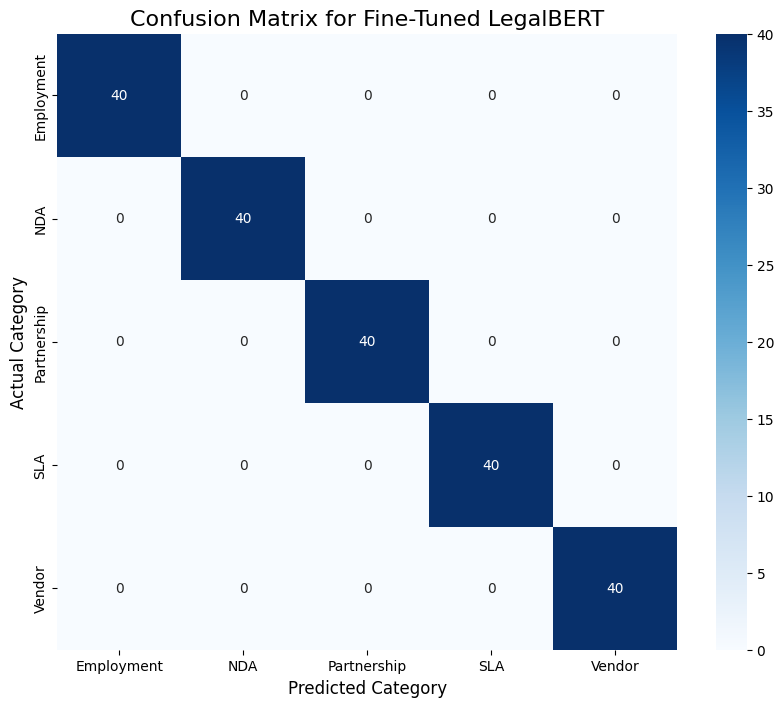

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- Visualize the Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Fine-Tuned LegalBERT', fontsize=16)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Actual Category', fontsize=12)
plt.show()

### 6. Interpretation of LegalBERT Results

The evaluation results show that the fine-tuned LegalBERT model also achieved a **perfect 100% accuracy** on our test set. Just like the baseline, the classification report and confusion matrix confirm that the model made zero errors, correctly identifying every document in the unseen data.

This outcome further validates that our synthetic dataset, with its distinct and non-overlapping keywords, represents a straightforward task for a powerful, context-aware model like LegalBERT. While the perfect score is excellent, it doesn't yet allow us to see the true advantages of a transformer model over a simpler TF-IDF approach. To properly compare the models and understand their trade-offs, we must now evaluate them on a more complex and realistic dataset with ambiguous language.